# Math Model

For a LLM in OpenAI, the total cost of choosing finetune is lower than or equal to that of prompt engineeering if and only if

$$
C_{FTTrain} + C_{FTUse} \cdot D \leq C_{PEUse} \cdot D
$$

where:

- $C_{FTTrain}$ is the cost of finetune
- $C_{FTUse}$ is the cost per day of using finetuned model
- $C_{PEUse}$ is the cost per day of using a foundation model with prompt engineering
- $D$ is the number of operational days

## Finetuning

In finetuning,

$$
C_{FTTrain} = T_{Data} \cdot E \cdot c_{Train}
$$

where:

- $T_{Data}$ is the number of tokens of the training dataset for finetune
- $E$ is the number of epochs in training
- $c_{Train}$ is the unit cost of training

## Finetuned Usage

Using a finetuned model,

$$
C_{FTUse} = (T_{FTIn} \cdot c_{FTIn} + T_{FTOut} \cdot c_{FTOut}) \cdot N
$$

where:

- $T_{PEIn}$ is the average number of tokens of an input using a finetuned model
- $C_{PEUseIn}$ is the unit cost of input using a finetuned model
- $T_{PEOut}$ is the average number of tokens of an output using a finetuned model
- $C_{PEUseOut}$ is the unit cost of output using a finetuned model

## Prompt Engineering Usage

Using a foundation model with prompt engineering,

$$
C_{PEUse} = (T_{PEIn} \cdot c_{PEUseIn} + T_{PEOut} \cdot c_{PEUseOut}) \cdot N
$$

where:

- $T_{PEIn}$ is the average number of tokens of an input using a foundation model
- $C_{PEUseIn}$ is the unit cost of input using a foundation model
- $T_{PEOut}$ is the average number of tokens of an output using a foundation model
- $C_{PEUseOut}$ is the unit cost of output using a foundation model
- $N$ is the estimated number of uses per user per operational day due to intermittent usage

## Key Conditions

Now, we want to investigate the conditions such that the statement is true, particularly for $D$ and $T_{Data}$.

Assume that $C_{PEUse} - C_{FTUse} > 0$. The most trivial inequality with subject $D$ can be obtained:

<aside>
💡

$$
D \geq \frac{C_{FTTrain}}{C_{PEUse} - C_{FTUse}}
$$

</aside>

which indicates that we need to operate for at least $D$ days for the cost of choosing the finetune approach to be less than choosing the prompt engineering approach, if there is really such possibility.

Another inequality with subject $T_{Data}$ can be obtained:

<aside>
💡

$$
T_{Data} \leq \frac{(C_{PEUse} - C_{FTUse}) \cdot D}{E \cdot c_{Train}}
$$

</aside>

which indicates that the dataset has an upper bound to be cost-efficient enough to finetune, otherwise the finetune cost will be too large and it is impossible to cost less.

<aside>
❗

Note that $D \geq D_{min}$ and $T_{Data} \leq T_{max}$ are related by AND, if the results are negative, it means that $D \geq D_{min}$ is true but $T_{Data} \leq T_{max}$ is false. Therefore, it is impossible to be cost-efficient in such scenarios.

</aside>

## Intermittent Usage

$N$ can be modeled by [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution).

$$
f(k ; \lambda)=\operatorname{Pr}(X=k)=\frac{\lambda^k e^{-\lambda}}{k !}
$$

$$
p=F(x \mid \lambda)=e^{-\lambda} \sum_{i=0}^{\text {floor }(x)} \frac{\lambda^i}{i !}
$$

Consider that ChatGPT Plus: 50 messages per 3 hours per user ($\lambda = \frac{50}{3}$).

$\operatorname{P}(X\leq 23)\approx 0.95$ and $\operatorname{P}(X\leq 27)\approx 0.99$

It means that we can be confident that 99% of users would have ≤ 27 uses per 3 hours. Suppose we take the maximum.

If we have 27 messages per 3 hours, then it means 9 messages per hour.

Assume $t = 8$ hours of active usage per day per user, then we have 72 messages per day per user.

❗ $\lambda$ and $t$ can also be modelled by normal distribution or even heavy-tailed distributions.

## Monte Carlo Simulation

[Monte Carlo simulation](https://en.wikipedia.org/wiki/Monte_Carlo_method) is a computational technique that allows you to account for uncertainty in your decision-making process. Here's how it works:

1. **Define a Model**:
    
    Identify a mathematical model of the system. In your case, you have already defined the cost relationships for fine-tuning and prompt engineering.
    
2. **Specify Uncertainties**:
    
    Identify which inputs to the model are uncertain. These are inputs for which you don't have a fixed value but instead have a range of possible values. For instance, $T_{Data}$ (the number of tokens of the training dataset for fine-tune) might vary.
    
3. **Assign Probability Distributions**:
    
    For each uncertain input, assign a probability distribution that describes the likelihood of different values. For instance, if you think $T_{Data}$  is likely to be around 1 million tokens but could be as low as 800,000 or as high as 1.2 million, you might model it as a normal distribution with a mean of 1 million and a standard deviation of 100,000.
    
4. **Perform Random Sampling**:
    
    For each simulation run, randomly sample a value for each uncertain input from its probability distribution.
    
5. **Compute the Model Outputs**:
    
    With the sampled input values, compute the model outputs (e.g., the total cost).
    
6. **Analyze the Results**:
    
    At the end of the simulation, you'll have a distribution of possible outcomes rather than a single deterministic value. This allows you to understand the range of possible outcomes, their likelihood, and any potential risks.
    

The beauty of Monte Carlo simulation is that it allows you to see all the possible outcomes of your decisions and assess the impact of risk, allowing for better decision-making under uncertainty.

# Monte Carlo Simulation

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Define a function to estimate tokens from words
def word_to_token(words):
    return int(words * 4/3)  # Rough estimate of 1.5 tokens per word

# Constants (Unit Costs)
# https://openai.com/pricing
FT_Model = {
    "babbage": {"c_Train": 0.0004, "c_FTIn": 0.0016, "c_FTOut": 0.0016},
    "davinci": {"c_Train": 0.006, "c_FTIn": 0.012, "c_FTOut": 0.012},
    "gpt-3.5": {"c_Train": 0.008, "c_FTIn": 0.012, "c_FTOut": 0.016}
}

PE_Model = {
    "gpt-3.5-4k": {"c_PEIn": 0.0015, "c_PEOut": 0.002, "T_model_max": 4096},
    "gpt-3.5-16k": {"c_PEIn": 0.003, "c_PEOut": 0.004, "T_model_max": 16385},
    "gpt-4-8k": {"c_PEIn": 0.03, "c_PEOut": 0.06, "T_model_max": 8192},
    "gpt-4-32k": {"c_PEIn": 0.06, "c_PEOut": 0.12, "T_model_max": 32768}
}

c_Train, c_FTIn, c_FTOut = FT_Model["gpt-3.5"].values()
c_PEIn, c_PEOut, T_model_max = PE_Model["gpt-3.5-16k"].values()

T_PEIn_mean = 0.8 * T_model_max

# Defining the parameter ranges
D = 90  # Number of operational days
T_Data_range = [3e6, 5e7]
E_range = [5, 30]
T_FTIn_range = [word_to_token(100), word_to_token(800)] # We should try to assume that T_FTIn is way smaller than T_PEIn
T_FTOut_range = [word_to_token(300), word_to_token(2000)]

# Parameters for the normal distribution modeling lambda
lambda_mean = 50/3
lambda_std = 0.1 * lambda_mean  # Assuming 10% of mean as standard deviation
time_mean = 8   # Hours usage per day
time_std = 0.1 * time_mean  # Assuming 10% of mean as standard deviation

# Monte Carlo Simulation
num_simulations = 200000

# Rerun the Monte Carlo Simulation with the updated parameter ranges
T_max_values = []
D_min_values = []

# Defining an empty DataFrame
df = pd.DataFrame(columns=['T_Data', 'E', 'T_FTIn', 'T_PEIn', 'T_FTOut', 'T_max', 'D_min'])

for _ in range(num_simulations):
    # Sample from the parameter ranges
    T_Data = np.random.uniform(T_Data_range[0], T_Data_range[1])
    E = np.random.randint(E_range[0], E_range[1] + 1)

    T_FTIn = np.random.uniform(T_FTIn_range[0], T_FTIn_range[1])
    T_FTOut = np.random.uniform(T_FTOut_range[0], T_FTOut_range[1])
    # Ensure that T_FTIn and T_FTOut are bounded by the max tokens
    T_FTIn = min(T_FTIn, T_model_max)
    T_FTOut = min(T_FTOut, T_model_max)

    T_PEIn = np.random.normal(T_PEIn_mean, 0.1 * T_PEIn_mean)
    # Ensure the sampled value of T_PEIn is bounded between T_FTIn and T_model_max
    T_PEIn = min(max(T_PEIn, T_FTIn), T_model_max)
    # Assume that the quality (length) of the outputs are the same
    # Ensure T_PEOut is the same as T_FTOut for each run
    T_PEOut = T_FTOut

    # Sample for Poisson distribution CDF at P=0.99
    lambda_sample = np.random.normal(lambda_mean, lambda_std)
    N = int(scipy.stats.poisson.ppf(0.99, lambda_sample)) * np.random.normal(time_mean, time_std)

    # Compute C_FTTrain, C_FTUse, and C_PE for the sampled values
    C_FTTrain = T_Data * E * c_Train
    C_FTUse = (T_FTIn * c_FTIn + T_FTOut * c_FTOut) * N
    C_PEUse = (T_PEIn * c_PEIn + T_PEOut * c_PEOut) * N
    
    # Compute T_max and D_min for the sampled values
    T_max_sample = (C_PEUse - C_FTUse) * D / (E * c_Train)
    D_min_sample = C_FTTrain / (C_PEUse - C_FTUse)
    
    # Append results to lists
    T_max_values.append(T_max_sample)
    D_min_values.append(D_min_sample)

    # Append results to DataFrame
    df.loc[len(df)] = [T_Data, E, T_FTIn, T_PEIn, T_FTOut, T_max_sample, D_min_sample]

# Filtering

In [14]:
# Filtering
df_filtered = df.copy()

# Trimming
# Might be bad but just for visualizations
df_filtered = df_filtered[(df_filtered['T_max'] > df_filtered['T_max'].quantile(0.05)) & (df_filtered['T_max'] < df_filtered['T_max'].quantile(0.95))]
df_filtered = df_filtered[(df_filtered['D_min'] > df_filtered['D_min'].quantile(0.05)) & (df_filtered['D_min'] < df_filtered['D_min'].quantile(0.95))]

# Realistic Filter
# Can go back here later
df_filtered = df_filtered[(df_filtered['T_max'] < 3e7)]
df_filtered = df_filtered[df_filtered['D_min'] < 500]
df_filtered.__len__()

31870

# Visualization

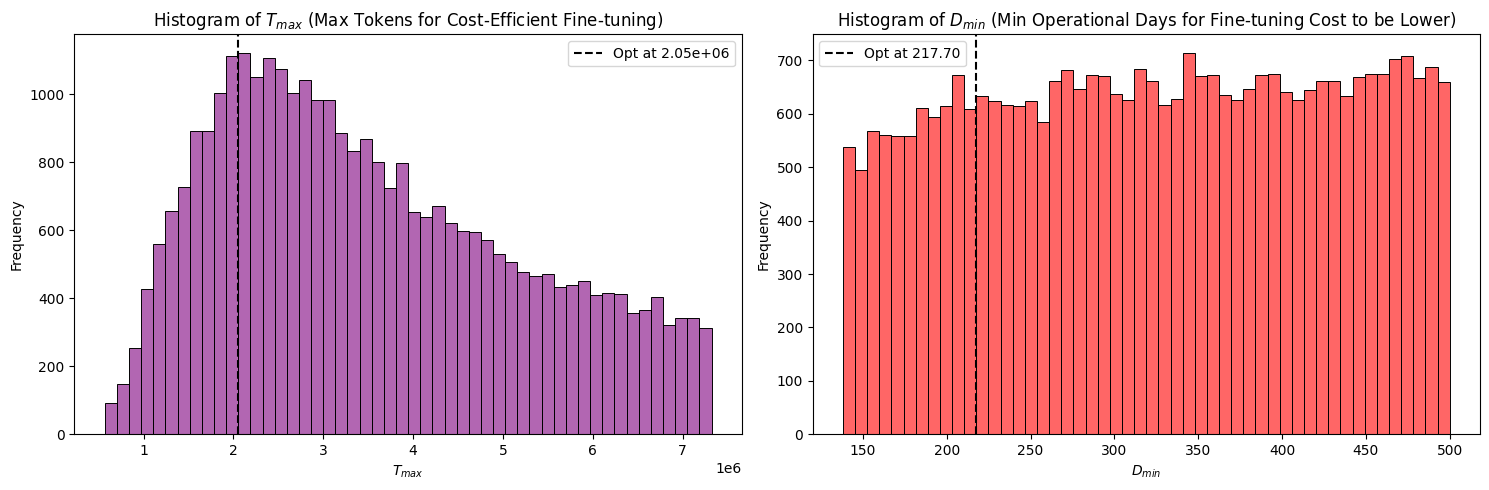

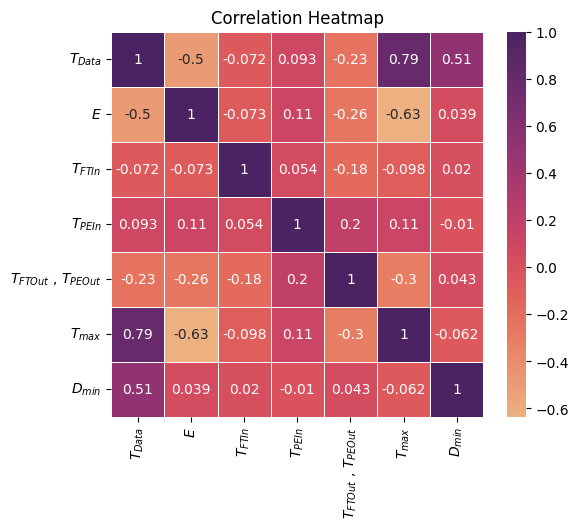

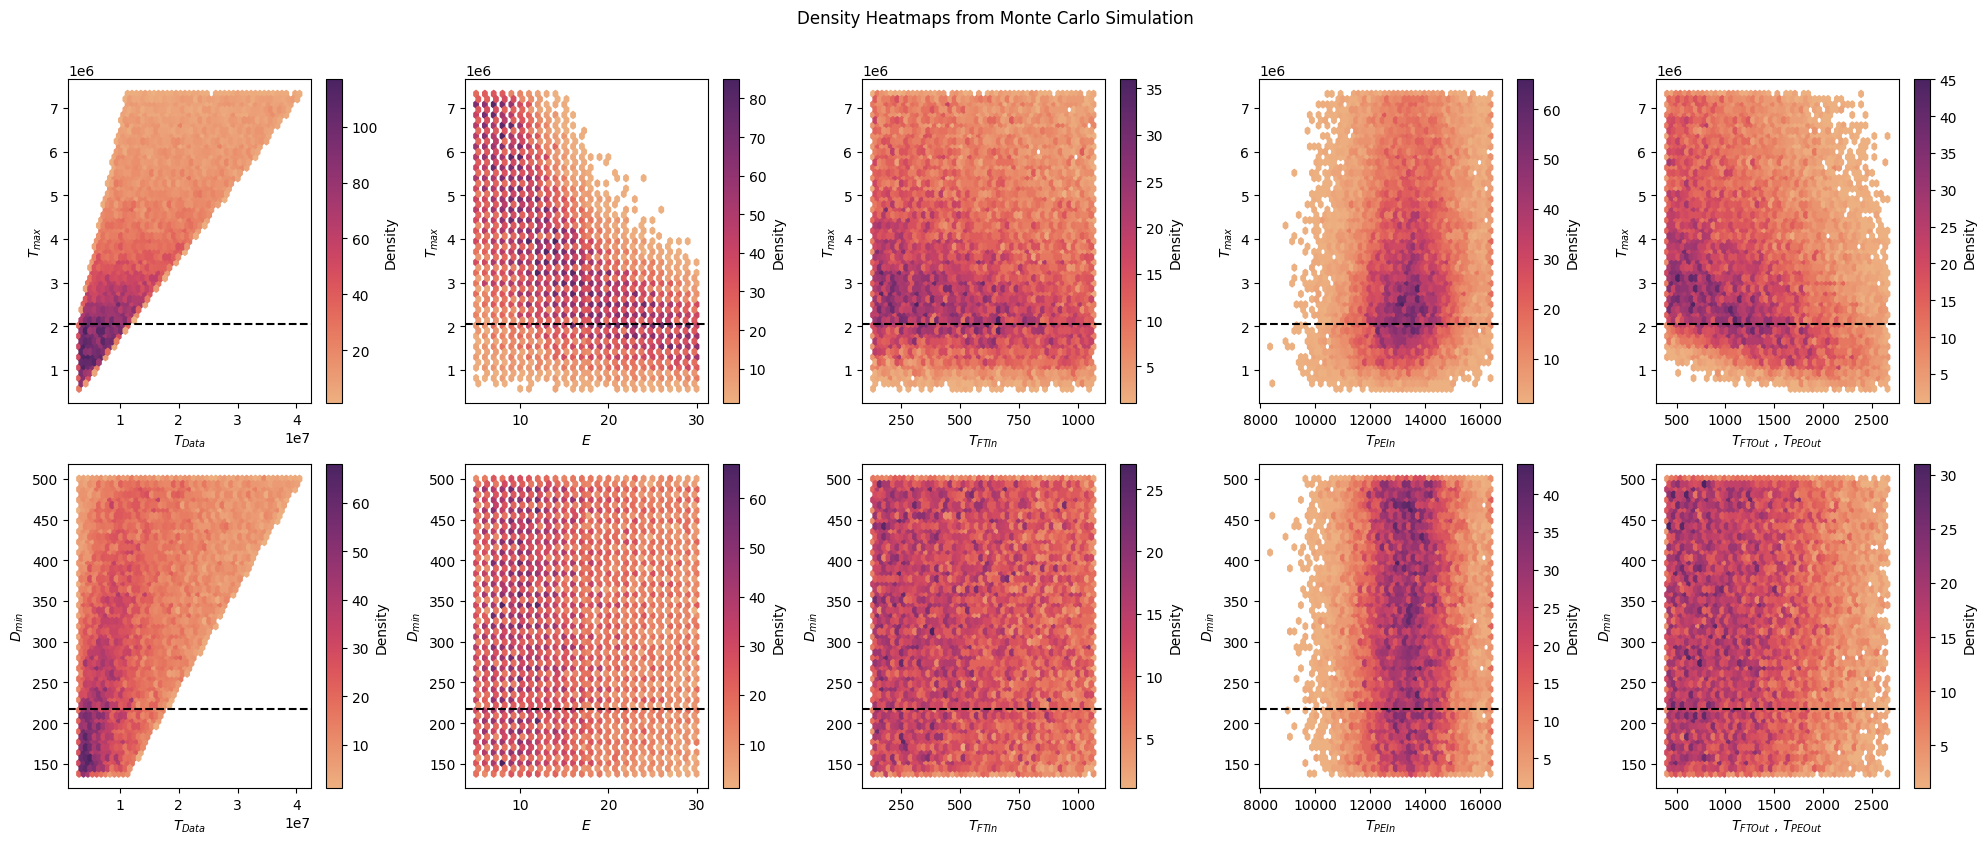

In [15]:
# DISTRIBUTION PLOT
# Find the mode for T_max and D_min using histograms
T_max_counts, T_max_bins = np.histogram(df_filtered['T_max'], bins=50)
T_max_opt = T_max_bins[np.argmax(T_max_counts)]     # Mode

D_min_counts, D_min_bins = np.histogram(df_filtered['D_min'], bins=50)
#D_min_opt = D_min_bins[np.argmax(D_min_counts)]     # Mode
D_min_opt = D_min_bins[np.argmax(T_max_counts)]    # Opt by T

# Plot histograms for T_max and D_min distributions using sns.histplot
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
sns.histplot(df_filtered['T_max'], bins=50, color='purple', kde=False, alpha=0.6)
plt.axvline(T_max_opt, color='k', linestyle='--', label='Opt at {:.2e}'.format(T_max_opt))
plt.title('Histogram of $T_{max}$ (Max Tokens for Cost-Efficient Fine-tuning)')
plt.xlabel('$T_{max}$')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df_filtered['D_min'], bins=50, color='red', kde=False, alpha=0.6)
plt.axvline(D_min_opt, color='k', linestyle='--', label='Opt at {:.2f}'.format(D_min_opt))
plt.title('Histogram of $D_{min}$ (Min Operational Days for Fine-tuning Cost to be Lower)')
plt.xlabel('$D_{min}$')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()



# CORRELATION HEATMAP
# Heatmap to visualize correlations between variables
labels = ['$T_{Data}$', '$E$', '$T_{FTIn}$', '$T_{PEIn}$', '$T_{FTOut}$ , $T_{PEOut}$', '$T_{max}$', '$D_{min}$']
plt.figure(figsize=(6,5))
sns.heatmap(df_filtered.corr(), annot=True, cmap="flare", linewidths=0.5, xticklabels=labels, yticklabels=labels)
plt.title("Correlation Heatmap")
plt.show()



# HEAT SWEEPS
# Plotting the hexbin density plots in a 2x6 grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# Labels for the plots
x_vars = ['$T_{Data}$', '$E$', '$T_{FTIn}$', '$T_{PEIn}$', '$T_{FTOut}$ , $T_{PEOut}$', '$T_{FTOut}$']
y_vars = ['$T_{max}$', '$D_{min}$']

# Columns in the dataframe
x_cols = ['T_Data', 'E', 'T_FTIn', 'T_PEIn', 'T_FTOut']
y_cols = ['T_max', 'D_min']

# Loop through to create hexbin plots
for i, y_col in enumerate(y_cols):
    for j, x_col in enumerate(x_cols):
        hb = axes[i, j].hexbin(df_filtered[x_col], df_filtered[y_col], cmap="flare", gridsize=50, mincnt=1)
        cb = plt.colorbar(hb, ax=axes[i, j])
        axes[i, j].set_xlabel(x_vars[j])
        axes[i, j].set_ylabel(y_vars[i])
        cb.set_label('Density')
        
        # Add horizontal lines for peaks
        if y_col == 'T_max':
            axes[i, j].axhline(T_max_opt, color='k', linestyle='--')
        if y_col == 'D_min':
            axes[i, j].axhline(D_min_opt, color='k', linestyle='--')

plt.tight_layout()
plt.suptitle("Density Heatmaps from Monte Carlo Simulation", y=1.05)
plt.show()